In [30]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Set random seed for reproducibility
np.random.seed(42)


In [31]:
# 1. DATA PREPARATION AND PROBLEM FORMULATION 

print("="*80)
print("WORLD TRADE PREDICTIVE MODELING")
print("="*80)

# Load cleaned data
df = pd.read_csv('../notebooks/world_trade_cleaned.csv')
country_df = df[df['Is_Country']].copy()

print(f"Dataset loaded: {country_df.shape[0]} rows, {country_df.shape[1]} columns")
print(f"Years available: {sorted(country_df['Year_Value'].unique())}")


WORLD TRADE PREDICTIVE MODELING
Dataset loaded: 7695 rows, 42 columns
Years available: [np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]


In [32]:
# 2. PROBLEM FORMULATION 

print("\n2. PROBLEM FORMULATION")
print("-"*40)

# We'll create three predictive problems:
# 1. Regression: Predict export value
# 2. Classification: Predict trade balance direction (surplus/deficit)
# 3. Time Series: Predict next year's trade metrics

print("Three modeling approaches will be implemented:")
print("1. Export Value Prediction (Regression)")
print("2. Trade Balance Direction Prediction (Classification)")
print("3. Trade Growth Rate Prediction (Regression)")




2. PROBLEM FORMULATION
----------------------------------------
Three modeling approaches will be implemented:
1. Export Value Prediction (Regression)
2. Trade Balance Direction Prediction (Classification)
3. Trade Growth Rate Prediction (Regression)


In [33]:
# 3. FEATURE ENGINEERING 

print("\n3. FEATURE ENGINEERING")
print("-"*40)

# Create lag features for time series analysis
country_df = country_df.sort_values(['Partner Name', 'Year_Value'])

# Create lag features (previous year's values)
lag_features = [
    'Export (US$ Thousand)_imputed',
    'Import (US$ Thousand)_imputed',
    'Trade_Balance',
    'Total_Trade',
    'AHS Simple Average (%)',
    'MFN Simple Average (%)'
]

for feature in lag_features:
    if feature in country_df.columns:
        country_df[f'{feature}_lag1'] = country_df.groupby('Partner Name')[feature].shift(1)
        country_df[f'{feature}_lag2'] = country_df.groupby('Partner Name')[feature].shift(2)

# Create growth rate features
country_df['Export_Growth_Rate'] = country_df.groupby('Partner Name')['Export (US$ Thousand)_imputed'].pct_change()
country_df['Import_Growth_Rate'] = country_df.groupby('Partner Name')['Import (US$ Thousand)_imputed'].pct_change()

# Create rolling statistics
country_df['Export_3yr_avg'] = country_df.groupby('Partner Name')['Export (US$ Thousand)_imputed'].transform(
    lambda x: x.rolling(3, min_periods=1).mean())
country_df['Import_3yr_avg'] = country_df.groupby('Partner Name')['Import (US$ Thousand)_imputed'].transform(
    lambda x: x.rolling(3, min_periods=1).mean())

# Create interaction features
country_df['Export_Import_Ratio'] = country_df['Export (US$ Thousand)_imputed'] / (country_df['Import (US$ Thousand)_imputed'] + 1)
country_df['Tariff_Differential'] = country_df['AHS Simple Average (%)'] - country_df['MFN Simple Average (%)']

# Create regional aggregates as features
regional_stats = country_df.groupby(['Region', 'Year_Value']).agg({
    'Export (US$ Thousand)_imputed': ['mean', 'std'],
    'Import (US$ Thousand)_imputed': ['mean', 'std']
}).reset_index()

regional_stats.columns = ['Region', 'Year_Value', 
                         'Region_Export_Mean', 'Region_Export_Std',
                         'Region_Import_Mean', 'Region_Import_Std']

country_df = pd.merge(country_df, regional_stats, on=['Region', 'Year_Value'], how='left')

# Normalize by regional statistics
country_df['Export_Relative_to_Region'] = country_df['Export (US$ Thousand)_imputed'] / country_df['Region_Export_Mean']
country_df['Import_Relative_to_Region'] = country_df['Import (US$ Thousand)_imputed'] / country_df['Region_Import_Mean']

print(f"Total features after engineering: {len(country_df.columns)}")
print(f"Sample engineered features: {list(country_df.columns[-10:])}")




3. FEATURE ENGINEERING
----------------------------------------
Total features after engineering: 66
Sample engineered features: ['Export_3yr_avg', 'Import_3yr_avg', 'Export_Import_Ratio', 'Tariff_Differential', 'Region_Export_Mean', 'Region_Export_Std', 'Region_Import_Mean', 'Region_Import_Std', 'Export_Relative_to_Region', 'Import_Relative_to_Region']


In [34]:
# 4. PROBLEM 1: EXPORT VALUE PREDICTION 

print("\n4. PROBLEM 1: EXPORT VALUE PREDICTION (REGRESSION)")
print("-"*40)

# Prepare dataset for export prediction
export_features = [
    # Lag features
    'Export (US$ Thousand)_imputed_lag1',
    'Import (US$ Thousand)_imputed_lag1',
    'Trade_Balance_lag1',
    
    # Current year features (excluding export)
    'Import (US$ Thousand)_imputed',
    'AHS Simple Average (%)',
    'MFN Simple Average (%)',
    
    # Engineered features
    'Export_Import_Ratio',
    'Tariff_Differential',
    'Export_Relative_to_Region',
    
    # Regional features
    'Region_Export_Mean',
    'Region_Import_Mean'
]

# Target variable
target = 'Export (US$ Thousand)_imputed'

# Filter data with required features
export_df = country_df[export_features + [target] + ['Year_Value', 'Partner Name']].copy()
export_df = export_df.dropna()

print(f"Export prediction dataset: {export_df.shape}")

# Separate features and target
X_export = export_df[export_features]
y_export = export_df[target]

# Split data (by year for temporal validation)
train_mask = export_df['Year_Value'] < export_df['Year_Value'].max()
X_train_export = X_export[train_mask]
X_test_export = X_export[~train_mask]
y_train_export = y_export[train_mask]
y_test_export = y_export[~train_mask]

print(f"Train size: {X_train_export.shape}, Test size: {X_test_export.shape}")

# Scale features
scaler_export = StandardScaler()
X_train_scaled_export = scaler_export.fit_transform(X_train_export)
X_test_scaled_export = scaler_export.transform(X_test_export)




4. PROBLEM 1: EXPORT VALUE PREDICTION (REGRESSION)
----------------------------------------
Export prediction dataset: (7436, 14)
Train size: (7200, 11), Test size: (236, 11)


In [35]:
# 5. PROBLEM 2: TRADE BALANCE DIRECTION PREDICTION 

print("\n5. PROBLEM 2: TRADE BALANCE DIRECTION (CLASSIFICATION)")
print("-"*40)

# Create binary target: 1 for trade surplus, 0 for deficit
country_df['Trade_Surplus'] = (country_df['Trade_Balance'] > 0).astype(int)

# Features for classification
class_features = [
    'Export (US$ Thousand)_imputed_lag1',
    'Import (US$ Thousand)_imputed_lag1',
    'Export_Growth_Rate',
    'Import_Growth_Rate',
    'Export_Import_Ratio',
    'AHS Simple Average (%)',
    'MFN Simple Average (%)',
    'Region_Export_Mean',
    'Region_Import_Mean'
]

target_class = 'Trade_Surplus'

# Prepare classification dataset
class_df = country_df[class_features + [target_class] + ['Year_Value']].copy()
class_df = class_df.dropna()

print(f"Classification dataset: {class_df.shape}")
print(f"Class distribution:")
print(class_df[target_class].value_counts(normalize=True))

X_class = class_df[class_features]
y_class = class_df[target_class]

# Split data
train_mask_class = class_df['Year_Value'] < class_df['Year_Value'].max()
X_train_class = X_class[train_mask_class]
X_test_class = X_class[~train_mask_class]
y_train_class = y_class[train_mask_class]
y_test_class = y_class[~train_mask_class]

print(f"Train size: {X_train_class.shape}, Test size: {X_test_class.shape}")

# Scale features
scaler_class = StandardScaler()
X_train_scaled_class = scaler_class.fit_transform(X_train_class)
X_test_scaled_class = scaler_class.transform(X_test_class)



5. PROBLEM 2: TRADE BALANCE DIRECTION (CLASSIFICATION)
----------------------------------------
Classification dataset: (7432, 11)
Class distribution:
Trade_Surplus
1    0.724031
0    0.275969
Name: proportion, dtype: float64
Train size: (7196, 9), Test size: (236, 9)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
# 6. PROBLEM 3: TRADE GROWTH RATE PREDICTION 

print("\n6. PROBLEM 3: TRADE GROWTH RATE PREDICTION")
print("-"*40)

# Features for growth rate prediction
growth_features = [
    'Export (US$ Thousand)_imputed_lag1',
    'Import (US$ Thousand)_imputed_lag1',
    'Export_Growth_Rate',
    'Export_3yr_avg',
    'AHS Simple Average (%)',
    'MFN Simple Average (%)',
    'Export_Relative_to_Region',
    'Region_Export_Mean'
]

target_growth = 'Export_Growth_Rate'

# Prepare growth dataset
growth_df = country_df[growth_features + [target_growth] + ['Year_Value']].copy()
growth_df = growth_df.dropna()

print(f"Growth prediction dataset: {growth_df.shape}")

X_growth = growth_df[growth_features]
y_growth = growth_df[target_growth]

# Split data
train_mask_growth = growth_df['Year_Value'] < growth_df['Year_Value'].max()
X_train_growth = X_growth[train_mask_growth]
X_test_growth = X_growth[~train_mask_growth]
y_train_growth = y_growth[train_mask_growth]
y_test_growth = y_growth[~train_mask_growth]

print(f"Train size: {X_train_growth.shape}, Test size: {X_test_growth.shape}")

# Scale features
scaler_growth = StandardScaler()
X_train_scaled_growth = scaler_growth.fit_transform(X_train_growth)
X_test_scaled_growth = scaler_growth.transform(X_test_growth)




In [ ]:
# 7. FEATURE SELECTION 


print("\n7. FEATURE SELECTION ANALYSIS")
print("-"*40)

# Feature importance using Random Forest
print("\nExport Prediction - Feature Importance:")

rf_importance = RandomForestRegressor(n_estimators=100, random_state=42)
rf_importance.fit(X_train_scaled_export, y_train_export)

importances = pd.DataFrame({
    'Feature': export_features,
    'Importance': rf_importance.feature_importances_
}).sort_values('Importance', ascending=False)

print(importances.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(importances['Feature'][:15], importances['Importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Features for Export Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# Use SelectKBest for feature selection
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X_train_scaled_export, y_train_export)

selected_features = [export_features[i] for i in selector.get_support(indices=True)]
print(f"\nSelected features (KBest): {selected_features}")



In [ ]:
# 8. BASELINE MODELS


print("\n8. BASELINE MODEL TRAINING")
print("-"*40)

# Define baseline models for regression
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate regression models
print("\nExport Prediction Model Performance:")
print("-"*50)

regression_results = []

for name, model in regression_models.items():
    # Train model
    model.fit(X_train_scaled_export, y_train_export)
    
    # Predict
    y_pred = model.predict(X_test_scaled_export)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_export, y_pred)
    mse = mean_squared_error(y_test_export, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_export, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled_export, y_train_export, 
                               cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    regression_results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'CV_R2_Mean': cv_mean,
        'CV_R2_Std': cv_std
    })
    
    print(f"{name:20} R²: {r2:.4f} | RMSE: {rmse:,.0f} | CV R²: {cv_mean:.4f} ± {cv_std:.4f}")

regression_df = pd.DataFrame(regression_results).sort_values('R2', ascending=False)



In [ ]:
# 9. CLASSIFICATION MODELS 


print("\n9. CLASSIFICATION MODEL TRAINING")
print("-"*40)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

print("\nTrade Balance Classification Performance:")
print("-"*50)

classification_results = []

for name, model in classification_models.items():
    # Train model
    model.fit(X_train_scaled_class, y_train_class)
    
    # Predict
    y_pred = model.predict(X_test_scaled_class)
    y_pred_proba = model.predict_proba(X_test_scaled_class)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_class, y_pred)
    precision = precision_score(y_test_class, y_pred, average='weighted')
    recall = recall_score(y_test_class, y_pred, average='weighted')
    f1 = f1_score(y_test_class, y_pred, average='weighted')
    
    auc = roc_auc_score(y_test_class, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled_class, y_train_class, 
                               cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    classification_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': auc,
        'CV_Accuracy_Mean': cv_mean,
        'CV_Accuracy_Std': cv_std
    })
    
    print(f"{name:20} Accuracy: {accuracy:.4f} | F1: {f1:.4f} | AUC: {auc if auc else 'N/A':.4f}")

classification_df = pd.DataFrame(classification_results).sort_values('Accuracy', ascending=False)


In [36]:
# 10. GROWTH RATE PREDICTION MODELS 

print("\n10. GROWTH RATE PREDICTION MODELS")
print("-"*40)

growth_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

print("\nGrowth Rate Prediction Performance:")
print("-"*50)

growth_results = []

for name, model in growth_models.items():
    # Train model
    model.fit(X_train_scaled_growth, y_train_growth)
    
    # Predict
    y_pred = model.predict(X_test_scaled_growth)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_growth, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_growth, y_pred))
    r2 = r2_score(y_test_growth, y_pred)
    
    growth_results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    
    print(f"{name:20} R²: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

growth_df = pd.DataFrame(growth_results).sort_values('R2', ascending=False)



10. GROWTH RATE PREDICTION MODELS
----------------------------------------

Growth Rate Prediction Performance:
--------------------------------------------------


NameError: name 'X_train_scaled_growth' is not defined


11. MODEL COMPARISON
----------------------------------------


NameError: name 'classification_df' is not defined

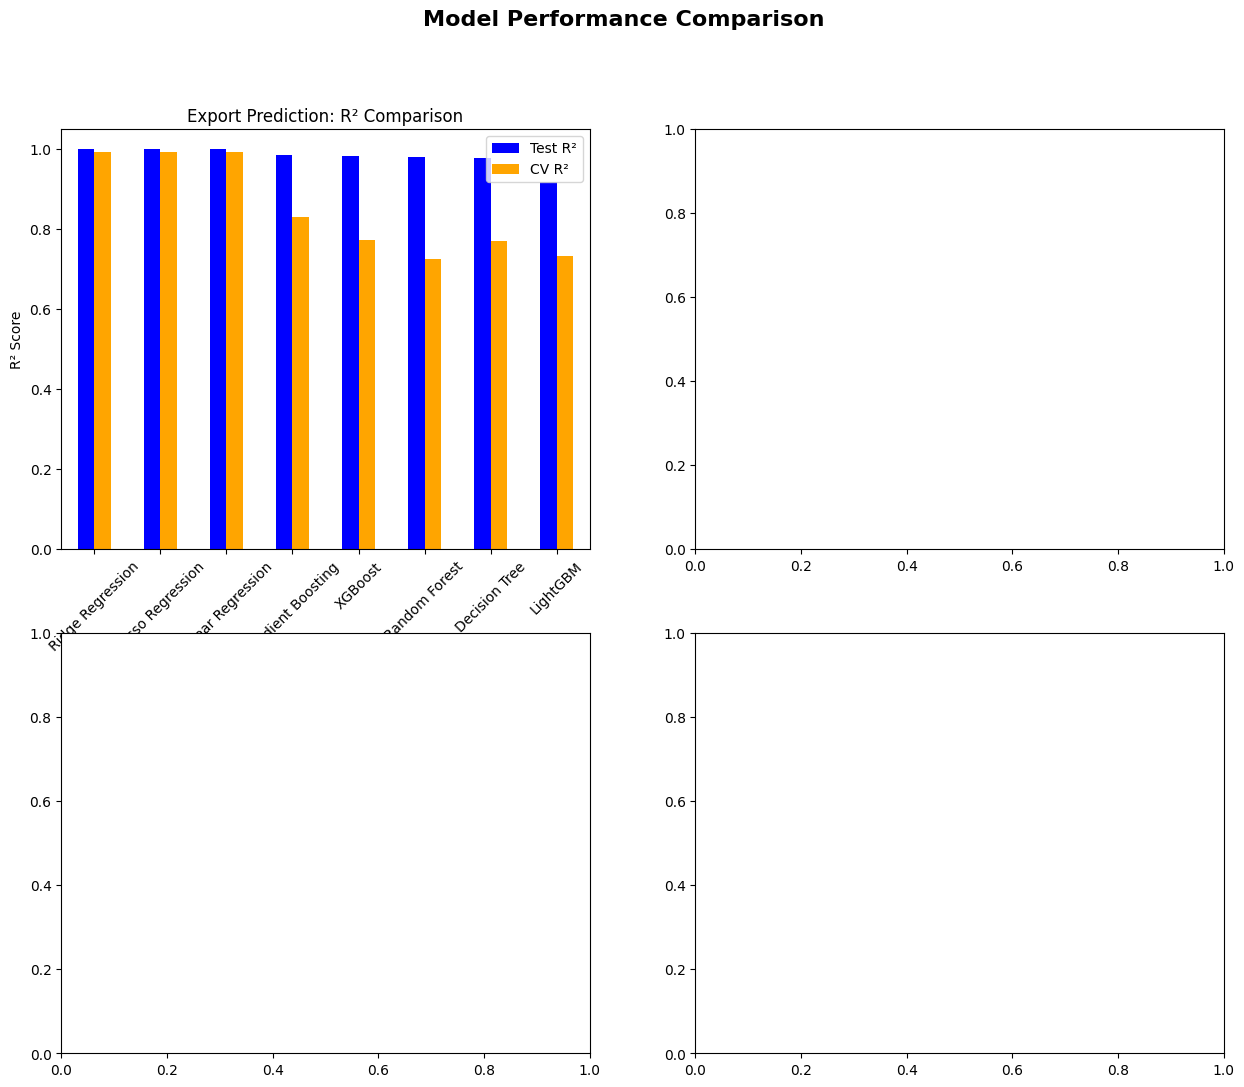

In [37]:
# 11. MODEL COMPARISON AND VISUALIZATION 

print("\n11. MODEL COMPARISON")
print("-"*40)

# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Regression models comparison
reg_plot = regression_df.plot(kind='bar', x='Model', y=['R2', 'CV_R2_Mean'], 
                             ax=axes[0, 0], color=['blue', 'orange'])
axes[0, 0].set_title('Export Prediction: R² Comparison')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(['Test R²', 'CV R²'])

# Classification accuracy
class_plot = classification_df.plot(kind='bar', x='Model', y=['Accuracy', 'CV_Accuracy_Mean'],
                                   ax=axes[0, 1], color=['green', 'purple'])
axes[0, 1].set_title('Trade Balance Classification: Accuracy Comparison')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(['Test Accuracy', 'CV Accuracy'])

# Error metrics for regression
axes[1, 0].bar(regression_df['Model'], regression_df['RMSE'], color='red', alpha=0.6)
axes[1, 0].set_title('Export Prediction: RMSE by Model')
axes[1, 0].set_ylabel('RMSE (Lower is better)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Feature importance from best model
best_reg_model_name = regression_df.iloc[0]['Model']
best_reg_model = regression_models[best_reg_model_name]
if hasattr(best_reg_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'Feature': export_features,
        'Importance': best_reg_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    axes[1, 1].barh(feature_imp['Feature'], feature_imp['Importance'])
    axes[1, 1].set_title(f'Feature Importance: {best_reg_model_name}')
    axes[1, 1].set_xlabel('Importance')
    axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



In [38]:
# 12. MODEL PERSISTENCE 

print("\n12. MODEL PERSISTENCE")
print("-"*40)

# Save the best models
best_export_model = regression_models[regression_df.iloc[0]['Model']]
best_class_model = classification_models[classification_df.iloc[0]['Model']]

# Retrain on full training data
best_export_model.fit(X_train_scaled_export, y_train_export)
best_class_model.fit(X_train_scaled_class, y_train_class)

# Save models
joblib.dump(best_export_model, 'best_export_model.pkl')
joblib.dump(best_class_model, 'best_classification_model.pkl')
joblib.dump(scaler_export, 'export_scaler.pkl')
joblib.dump(scaler_class, 'classification_scaler.pkl')

print("Models and scalers saved successfully:")
print("1. best_export_model.pkl - Best export prediction model")
print("2. best_classification_model.pkl - Best trade balance classification model")
print("3. export_scaler.pkl - Feature scaler for export model")
print("4. classification_scaler.pkl - Feature scaler for classification model")

# Save feature lists
with open('export_features.txt', 'w') as f:
    f.write('\n'.join(export_features))

with open('classification_features.txt', 'w') as f:
    f.write('\n'.join(class_features))

print("Feature lists saved to text files")



12. MODEL PERSISTENCE
----------------------------------------


NameError: name 'classification_df' is not defined

In [ ]:
# 13. PREDICTION DEMONSTRATION


print("\n13. PREDICTION DEMONSTRATION")
print("-"*40)

# Make sample predictions
sample_idx = 0
if len(X_test_scaled_export) > 0:
    sample_prediction = best_export_model.predict(X_test_scaled_export[sample_idx:sample_idx+1])
    actual_value = y_test_export.iloc[sample_idx]
    
    print(f"\nSample Export Prediction:")
    print(f"Predicted: ${sample_prediction[0]:,.2f}")
    print(f"Actual: ${actual_value:,.2f}")
    print(f"Error: ${abs(sample_prediction[0] - actual_value):,.2f}")
    print(f"Percentage Error: {abs((sample_prediction[0] - actual_value)/actual_value)*100:.2f}%")

# Classification prediction
if len(X_test_scaled_class) > 0:
    sample_class_pred = best_class_model.predict(X_test_scaled_class[sample_idx:sample_idx+1])
    sample_class_proba = best_class_model.predict_proba(X_test_scaled_class[sample_idx:sample_idx+1])
    
    print(f"\nSample Trade Balance Classification:")
    print(f"Predicted: {'Surplus' if sample_class_pred[0] == 1 else 'Deficit'}")
    print(f"Confidence: {max(sample_class_proba[0]):.2%}")
    print(f"Actual: {'Surplus' if y_test_class.iloc[sample_idx] == 1 else 'Deficit'}")